In [1]:
import kelp_param
import kelp3d_objs as k3
import ipyparallel as ipp
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import ipyvolume as ipv
import scipy.optimize as opt

In [2]:
from scipy.sparse import coo_matrix

In [3]:
remote_config = kelp_param.ParamSpanRemoteConfig()
ipp.Client().ids

/home/oliver/local/miniconda3/envs/widgets/lib/python3.6/site-packages/ipyparallel/client/client.py:458: RuntimeWarning: 
            Controller appears to be listening on localhost, but not on this machine.
            If this is true, you should specify Client(...,sshserver='you@oliver-arch')
            or instruct your controller to listen on an external IP.
  RuntimeWarning)


[0]

In [4]:
# Hard-coded parameters
absorptance_kelp =  0.8 # (%)
rope_spacing = 5.0 # (m)
zmin, zmax = 0.0, 10.0 # (m)
nz=12

dz = (zmax-zmin)/nz
z = np.linspace(zmin+0.5*dz, zmax-0.5*dz, nz)

# Surface Irradiance
I0 = 50.0 # (W/m^2)
phi_s = 0 # (rad)
theta_s = 0 # (rad)
decay = 0 # (?) - light (practically) only from directly above

# Calculated or otherwise boring parameters
xmin = -rope_spacing/2
xmax = rope_spacing/2
ymin = -rope_spacing/2
ymax = rope_spacing/2

# Solver parameters
tol_abs = 1e-6
tol_rel = 1e-6
maxiter_inner = 50
maxiter_outer = 50
gmres_wrapper = k3.gmres_wrapper

const = (rope_spacing, zmin, zmax, nz, I0, phi_s, theta_s, decay, xmin, xmax, ymin, ymax, absorptance_kelp,
         tol_abs, tol_rel, maxiter_inner, maxiter_outer, gmres_wrapper)

# Compare Asymptotics to Finite Difference

In [5]:
# Hard-coded parameters
absorptance_kelp =  0.8 # (%)
rope_spacing = 4.0 # (m)
zmin, zmax = 0.0, 10.0 # (m)
nz=24

dz = (zmax-zmin)/nz
z = np.linspace(zmin+0.5*dz, zmax-0.5*dz, nz)

# Surface Irradiance
I0 = 2*np.pi # (W/m^2)
phi_s = 0 # (rad)
theta_s = 0 # (rad)
decay = 1 # (?) - light (practically) only from directly above

# Calculated or otherwise boring parameters
xmin = -rope_spacing/2
xmax = rope_spacing/2
ymin = -rope_spacing/2
ymax = rope_spacing/2

# Solver parameters
tol_abs = 1e-6
tol_rel = 1e-6
maxiter_inner = 50
maxiter_outer = 50
gmres_wrapper = k3.gmres_wrapper

const = (rope_spacing, zmin, zmax, nz, I0, phi_s, theta_s, decay, xmin, xmax, ymin, ymax, absorptance_kelp,
         tol_abs, tol_rel, maxiter_inner, maxiter_outer, gmres_wrapper)

In [10]:
# Set parameters
a_water = 1.0
b = 0.5
ns = 2
na = 2
kelp_profile='none'
max_scatter = 5

# GMRES
gmres_results = kelp_param.kelp_calculate(
    a_water,
    b,
    ns,
    na,
    kelp_profile,
    gmres_flag=True,
    num_scatters=0,
    const=const
)

res_list = []
save_list = []

p_kelp = gmres_results['p_kelp']
true_irrad = gmres_results['irradiance']
true_rad = gmres_results['radiance']
true_perceived_irrad = np.sum(p_kelp*true_irrad, axis=(0,1)) / np.sum(p_kelp, axis=(0,1)) / np.pi

# Run scattering cases
for n in range(max_scatter+1):
    print("n={}".format(n))
    #print("const={}".format(const))
    compute_results = kelp_param.kelp_calculate(
        a_water,
        b,
        ns,
        na,
        kelp_profile,
        gmres_flag=False,
        num_scatters=n,
        const=const
    )

    rad = compute_results['radiance']
    rad_err = np.mean(rad - true_rad)
    irrad = compute_results['irradiance']
    irrad_err = np.abs(true_irrad - irrad).mean(axis=(0,1))
    # Perceived irradiance for each depth layer
    perceived_irrad = np.sum(p_kelp*irrad, axis=(0,1)) / np.sum(p_kelp, axis=(0,1))
    perc_err = np.abs(true_perceived_irrad - perceived_irrad)

    save_vals = {
        'rad_abs_err': rad_err,
        'rad_rel_err': rad_err / np.abs(gmres_results['radiance']),
        'irrad': irrad.mean(axis=(0,1)),
        'irrad_abs_err': irrad_err,
        'irrad_rel_err': irrad_err / np.abs(true_irrad).mean(axis=(0,1)),
        'perceived_irrad': perceived_irrad,
        'perc_abs_err': perc_err,
        'perc_rel_err': perc_err / np.abs(true_perceived_irrad)
    }

    res_list.append(compute_results)
    save_list.append(save_vals)

dz = 0.4166666666666667
theoretical max_kelp = 0.24
Max kelp = 0.0
GMRES Success!
n=0
dz = 0.4166666666666667
theoretical max_kelp = 0.24
Max kelp = 0.0
n=1
dz = 0.4166666666666667
theoretical max_kelp = 0.24
Max kelp = 0.0
n=2
dz = 0.4166666666666667
theoretical max_kelp = 0.24
Max kelp = 0.0
n=3
dz = 0.4166666666666667
theoretical max_kelp = 0.24
Max kelp = 0.0
n=4
dz = 0.4166666666666667
theoretical max_kelp = 0.24
Max kelp = 0.0
n=5
dz = 0.4166666666666667
theoretical max_kelp = 0.24
Max kelp = 0.0


/home/oliver/local/miniconda3/envs/widgets/lib/python3.6/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in true_divide
/home/oliver/local/miniconda3/envs/widgets/lib/python3.6/site-packages/ipykernel_launcher.py:49: RuntimeWarning: invalid value encountered in true_divide


# Plot Convergence Curves

In [11]:
def exp_fun(x, c, a):
    return c*np.exp(-a*x)

zc = np.linspace(zmin, zmax, 101)

true_avg_irrad = true_irrad.mean(axis=(0,1))
(true_c, true_a_eff),_ = opt.curve_fit(exp_fun, z, true_avg_irrad, [1, a_water])

gmres: a_eff = 1.18, I0=6.97
n=0: a_eff=1.00, I0=6.28
n=1: a_eff=1.33, I0=6.44
n=2: a_eff=1.24, I0=6.30
n=3: a_eff=1.26, I0=6.33
n=4: a_eff=1.25, I0=6.33
n=5: a_eff=1.25, I0=6.33


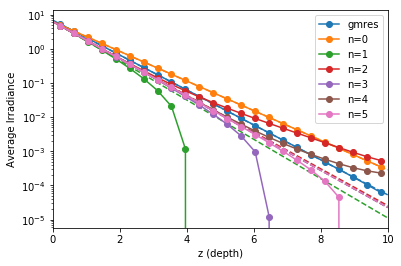

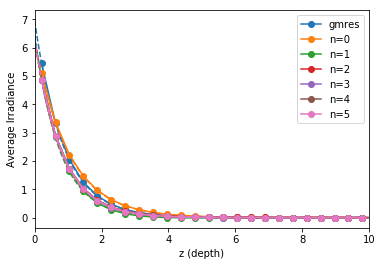

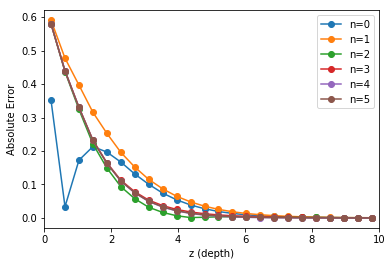

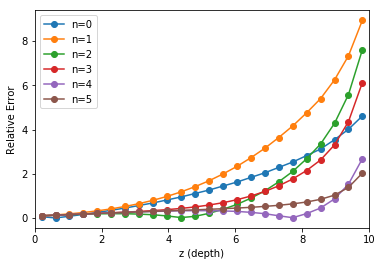

In [12]:
plt.figure()
l, = plt.plot(z, true_avg_irrad, 'o-', label='gmres')
print("gmres: a_eff = {:.2f}, I0={:.2f}".format(true_a_eff, true_c))
plt.plot(zc, exp_fun(zc, true_c, true_a_eff), '--', c=l.get_color())
for n, irrad in enumerate([s['irrad'] for s in save_list]):
    (c, a_eff,),_ = opt.curve_fit(exp_fun, z, irrad, [1, a_water])
    print("n={}: a_eff={:.2f}, I0={:.2f}".format(n, a_eff, c))
    l, = plt.plot(z, irrad, 'o-', label='n={}'.format(n))
    plt.plot(zc, exp_fun(zc, c, a_eff), '--', c=l.get_color())
plt.xlim(zmin, zmax)
plt.yscale('log')
plt.legend()
plt.xlabel('z (depth)')
plt.ylabel('Average Irradiance')

plt.figure()
l, = plt.plot(z, true_avg_irrad, 'o-', label='gmres')
plt.plot(zc, exp_fun(zc, true_c, true_a_eff), '--', c=l.get_color())
for n, irrad in enumerate([s['irrad'] for s in save_list]):
    (c, a_eff,),_ = opt.curve_fit(exp_fun, z, irrad, [1, a_water])
    l, = plt.plot(z, irrad, 'o-', label='n={}'.format(n))
    plt.plot(zc, exp_fun(zc, c, a_eff), '--', c=l.get_color())
plt.xlim(zmin, zmax)
plt.yscale('linear')
plt.legend()
plt.xlabel('z (depth)')
plt.ylabel('Average Irradiance')

plt.figure()
for n, err in enumerate([s['irrad_abs_err'] for s in save_list]):
    plt.plot(z, err, 'o-', label='n={}'.format(n))
plt.xlim(zmin, zmax)
plt.yscale('linear')
plt.legend()
plt.xlabel('z (depth)')
plt.ylabel('Absolute Error')

plt.figure()
for n, err in enumerate([s['irrad_rel_err'] for s in save_list]):
    plt.plot(z, err, 'o-', label='n={}'.format(n))
plt.xlim(zmin, zmax)
plt.yscale('linear')
plt.legend()
plt.xlabel('z (depth)')
plt.ylabel('Relative Error')

plt.show()

In [13]:
awfklawjhelfkaj

NameError: name 'awfklawjhelfkaj' is not defined

In [ ]:
# Load coefficient matrix
row = np.loadtxt("row.txt") - 1
col = np.loadtxt("col.txt") - 1
data = np.loadtxt("data.txt")
rhs = np.loadtxt("rhs.txt")
mat = coo_matrix((data, (row, col)))
# Drop stored zeros
mat = coo_matrix(mat.toarray())

In [ ]:
def full_arr_str(arr):
    return np.array_repr(arr, precision=2, max_line_width=200).replace(', ',',').replace('array([','').replace(']])','] ').replace('       ','').replace(',',' ')
def print_full(arr):
    print(full_arr_str(arr))

def print_mat_eq(A, b):
    lines1, lines2 = map(lambda s: full_arr_str(s).split('\n'), (A, b.reshape(len(b),1)))
    print('\n'.join([(' '*5).join([l1, l2]) for l1, l2 in zip(lines1, lines2)]))

In [ ]:
print_mat_eq(mat.toarray(), rhs)

In [ ]:
od = np.logical_and(
    mat.row != mat.col,
    np.abs(mat.data)>1e-6
)

In [ ]:
tuple(zip(*map(lambda a: a[np.abs(mat.data)>1e-6], (mat.row, mat.col, mat.data))))

In [ ]:
np.diag(mat.toarray())

# Examine Effective A

In [ ]:
a_list = np.linspace(0, 10, 10)
b = 0.0
ns = 1
na = 2
kelp_profile='none'
max_scatter = 2

a_eff_list = np.zeros_like(a_list)
I0_eff_list = np.zeros_like(a_list)

for i, a in enumerate(a_list):
    # GMRES
    gmres_results = kelp_param.kelp_calculate(
        a,
        b,
        ns,
        na,
        kelp_profile,
        gmres_flag=True,
        num_scatters=0,
        const=const
    )
    true_irrad = gmres_results['irradiance']
    true_avg_irrad = true_irrad.mean(axis=(0,1))
    (I0_eff_list[i], a_eff_list[i]),_ = opt.curve_fit(exp_fun, z, true_avg_irrad, [1, a_water])

In [ ]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

ax1.plot(a_list, a_eff_list**2,y 'C0', label='a_eff')
ax1.plot(a_list, a_list, '--C0', label='Correct')
ax2.plot(a_list, I0_eff_list, 'C1', label='I0_eff')
ax2.plot(a_list, I0+0*a_list, '--C1', label='Correct')
ax1.set_xlabel('Given a')
ax1.set_ylabel('Effective a')
ax2.set_ylabel('Effective I0')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.show()